In [1]:
import cooltools
import bioframe
import cooler
import pandas as pd
from HMMC import HMMC, fileprocessing
from importlib import reload  
import numpy as np
from cooltools import eigdecomp
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
cooldir = '/pollard/data/chromatin_organization/rao2014/distiller-0.3.1_hg19/results'
fasta_file='/pollard/data/vertebrate_genomes/human/hg19/hg19/hg19.fa'

In [3]:
cools = fileprocessing.get_files(cooldir)

In [4]:
df = fileprocessing.cools_df(cools, resolution = 50000)

In [5]:
df

,cell_line,assembly,path,cooler
0,NHEK,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""NHEK_inSitu_MboI.hg19.mapq_30.1000.mc..."
1,IMR90,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""IMR90_inSitu_MboI.hg19.mapq_30.1000.m..."
2,K562,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""K562_inSitu_MboI.hg19.mapq_30.1000.mc..."
3,HUVEC,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""HUVEC_inSitu_MboI.hg19.mapq_30.1000.m..."
4,HMEC,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""HMEC_inSitu_MboI.hg19.mapq_30.1000.mc..."
5,KBM7,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""KBM7_inSitu_MboI.hg19.mapq_30.1000.mc..."
6,GM12878,hg19,/pollard/data/chromatin_organization/rao2014/d...,"<Cooler ""GM12878_inSitu_MboI.hg19.mapq_30.1000..."


In [6]:
gc_dict = fileprocessing.get_gc(df, fasta_file)

In [7]:
gc_dict['hg19'].head()

,chrom,start,end,weight,GC
0,chr1,0,50000,NaN,0.484250
1,chr1,50000,100000,NaN,0.376740
2,chr1,100000,150000,NaN,0.429960
3,chr1,150000,200000,NaN,0.447314
4,chr1,200000,250000,NaN,0.410796


In [8]:
c = df.iloc[6].cooler

In [9]:
chromsizes = c.chromsizes
chromsizes.head()

name
chr1    249250621
chr2    243199373
chr3    198022430
chr4    191154276
chr5    180915260
Name: length, dtype: int32

In [10]:
midpoints = bioframe.fetch_centromeres('hg19')
midpoints.head()

,chrom,start,end,mid
0,chr1,121500000,128900000,125200000
1,chr10,38000000,42300000,40150000
2,chr11,51600000,55700000,53650000
3,chr12,33300000,38200000,35750000
4,chr13,16300000,19500000,17900000


In [11]:
chromarms = bioframe.genomeops.make_chromarms(chromsizes, midpoints)
chromarms.head()

,chrom,start,end,name
0,chr1,0,125200000,chr1p
1,chr1,125200000,249250621,chr1q
2,chr10,0,40150000,chr10p
3,chr10,40150000,135534747,chr10q
4,chr11,0,53650000,chr11p


In [12]:
regions = [(row[0], row[1], row[2]) for index, row in chromarms.iterrows()]

In [13]:
cis_val, cis_eig = eigdecomp.cooler_cis_eig(
                c, 
                gc_dict['hg19'], 
                regions = regions,
                n_eigs=3, 
                balance=True,
                ignore_diags = 10, clip_percentile=99)

In [14]:
def get_corr(masked_track):
    for chrom in masked_track.chrom.unique():
        mask = masked_track.chrom==chrom
        corrs = [stats.pearsonr(masked_track[mask]['E' + str(i)].values, masked_track[mask]['GC'].values)[0] for i in range(1, 4)]

        print(chrom, corrs)

In [15]:
masked_track = cis_eig[~cis_eig['E1'].isna()]
get_corr(masked_track)

chr1 [0.5863703574301379, 0.20887934945468156, 0.34580262108669013]
chr2 [0.5227885507057974, 0.4551965110026525, -0.0783792109064218]
chr3 [0.6595880957023125, 0.2130503717819337, 0.28787300730292026]
chr4 [0.46740178228559115, 0.2244744174949804, 0.2809897661183371]
chr5 [0.5571833790748342, 0.31622525665946244, 0.1911232155095279]
chr6 [0.49557810389923057, 0.05876008435860212, 0.1609490857150486]
chr7 [0.5825768374380789, 0.34063975457090184, 0.21188170534880274]
chr8 [0.4964213765257928, 0.24103832097553146, -0.0003675098898783627]
chr9 [0.5802290555210841, 0.3334249461854339, 0.01345673304150112]
chr10 [0.35387701337885524, 0.5503145529236867, 0.2404595611821298]
chr11 [0.6738445181010351, 0.15063583714038242, 0.24329629143672404]
chr12 [0.6286884522776208, 0.311789800719787, 0.24310296268679168]
chr13 [0.5279944568512068, -0.07764133701325909, 0.41875427010796284]
chr14 [0.6151079566283828, 0.10570977826364088, 0.15410615954533236]
chr15 [0.41361760832591693, 0.07481159212246655

In [16]:
cis_val2, cis_eig2 = eigdecomp.cooler_cis_eig(
                c, 
                gc_dict['hg19'], 
                regions = [(chrom, 0, c.chromsizes[chrom]) for chrom in c.chromnames],
                n_eigs=3, 
                balance=True,
                ignore_diags = 10, clip_percentile=99)

In [17]:
masked_track2 = cis_eig2[~cis_eig2['E1'].isna()]
get_corr(masked_track2)

chr1 [0.6466363493157578, 0.38374587337614563, 0.11003335083158723]
chr2 [0.5154302713967023, 0.5458181937156704, 0.0891043096925276]
chr3 [0.6874865870465964, 0.3357997703620758, -0.08791164380217142]
chr4 [0.5290036516373862, 0.17653233608452418, 0.12231018479864554]
chr5 [0.5568835958214121, 0.2280513510700204, 0.414620891295274]
chr6 [0.5938188519175683, -0.15263773657558408, 0.2423993115466446]
chr7 [0.5535198432450478, 0.5144218092437028, 0.11717512860560281]
chr8 [0.4642529838825884, 0.39617454028371946, 0.4064741556569348]
chr9 [0.6523419371690511, -0.10186710693551174, 0.3351599864917103]
chr10 [0.3372668426631099, 0.49034890045921886, 0.09580035720489163]
chr11 [0.6898128789791588, 0.13740935917690514, -0.09486585485479743]
chr12 [0.6374526453637082, 0.42224103057644297, 0.08715353739690049]
chr13 [0.5282201488990541, -0.07758280428296536, 0.4182138454395834]
chr14 [0.6151305440980643, 0.1057649103387711, 0.15411605830432595]
chr15 [0.41359915476244113, 0.07380845354994801, 0

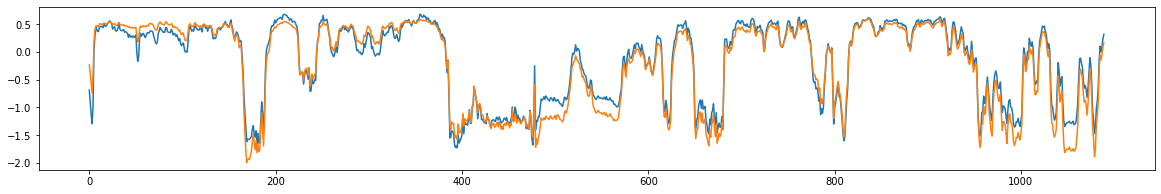

In [18]:
plt.figure(figsize=(20, 3))
chrom = 'chr19'
y1 = masked_track[masked_track.chrom == chrom]['E1'].values
plt.plot(y1)
y2 = masked_track2[masked_track2.chrom == chrom]['E1'].values
plt.plot(y2)

In [19]:
hmm_track = HMMC.auto_analyze(cis_eig)

Fitting a model with 34 free scalar parameters with only 26 data points will result in a degenerate solution.
Fitting a model with 47 free scalar parameters with only 26 data points will result in a degenerate solution.


[ 2. -2.  0. ...  4. -3.  0.]


In [20]:
hmm_track

,chrom,start,end,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM4,HMM5,HMM6,HMM5_2
0,chr1,0,50000,NaN,0.484250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,50000,100000,NaN,0.376740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,100000,150000,NaN,0.429960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,150000,200000,NaN,0.447314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,200000,250000,NaN,0.410796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61923,chrY,59200000,59250000,NaN,0.388820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61924,chrY,59250000,59300000,NaN,0.398220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61925,chrY,59300000,59350000,NaN,0.479240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61926,chrY,59350000,59373566,NaN,0.563615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


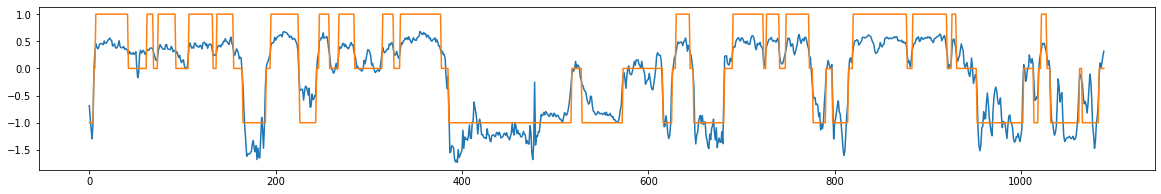

In [37]:
plt.figure(figsize=(20, 3))
chrom = 'chr19'
mask = (~hmm_track['E1'].isna()) & (hmm_track.chrom == chrom)
y1 = hmm_track[mask]['E1'].values
plt.plot(y1)
y2 = hmm_track[mask]['HMM3'].values  -1
plt.plot(y2)